In [1]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 21.2 MB/s 
     |████████████████████████████████| 451 kB 57.3 MB/s 
     |████████████████████████████████| 182 kB 60.1 MB/s 
     |████████████████████████████████| 7.6 MB 52.8 MB/s 
     |████████████████████████████████| 132 kB 68.5 MB/s 
     |████████████████████████████████| 212 kB 52.9 MB/s 
     |████████████████████████████████| 127 kB 63.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# Imports and Constants

In [2]:
import warnings
# warnings.filterwarnings('ignore')

import os
import pandas as pd
import datasets
import numpy as np
import torch
from transformers import AutoTokenizer
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
# use the GPU or MPS if available
if torch.cuda.is_available():       
    DEVICE = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print('Using Apple MPS')

else:
    print('No GPU available, using the CPU instead.')
    DEVICE = torch.device("cpu")

#DEVICE = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# Load dataset from huggingface datasets

In [4]:
## Download and load the datasets from HuggingFace

# Define dataset names and dataset sizes
dataset_name = 'polyglot_ner'
subset_name = 'de'

trainSize_small = 1000
trainSize_big = 3000
testSize = 2000

# Load the datasets
trainSmall_dataset = datasets.load_dataset(dataset_name, subset_name, split='train[:{}]'.format(trainSize_small))
trainBig_dataset = datasets.load_dataset(dataset_name, subset_name, split='train[:{}]'.format(trainSize_big))
test_dataset = datasets.load_dataset(dataset_name, subset_name, split='train[{}:{}]'.format(trainSize_big, trainSize_big+testSize))



Generating train split:   0%|          | 0/547578 [00:00<?, ? examples/s]

Dataset polyglot_ner downloaded and prepared to /root/.cache/huggingface/datasets/polyglot_ner/de/1.0.0/bb2e45c90cd345c87dfd757c8e2b808b78b0094543b511ac49bc0129699609c1. Subsequent calls will reuse this data.


## Inspect the training data

In [5]:
# Show structure of the datasets
print(trainSmall_dataset)
print(trainBig_dataset)

# Print the first sample of the training dataset
display(trainSmall_dataset[0])

Dataset({
    features: ['id', 'lang', 'words', 'ner'],
    num_rows: 1000
})
Dataset({
    features: ['id', 'lang', 'words', 'ner'],
    num_rows: 3000
})


{'id': '0',
 'lang': 'de',
 'words': ['Im',
  'Jahr',
  '2011',
  'hatte',
  'die',
  'Gemeinde',
  'etwas',
  'mehr',
  'als',
  '3700',
  'Mitglieder',
  '.'],
 'ner': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}

# Preprocess words and ner tags
To make later processing easier, we join the words and ner tags into a single string, separated by a space. This is done by the function `join_words_ner_tags` below.

For this, we first need to convert the downloaded dataset into a pandas dataframe.

In [6]:
## Extract words and labels from the datasets and convert them to a pandas dataframe

# Extract words and labels from the datasets
trainSmall_words = [sample['words'] for sample in trainSmall_dataset]
trainSmall_labels = [sample['ner'] for sample in trainSmall_dataset]

trainBig_words = [sample['words'] for sample in trainBig_dataset]
trainBig_labels = [sample['ner'] for sample in trainBig_dataset]

test_words = [sample['words'] for sample in test_dataset]
test_labels = [sample['ner'] for sample in test_dataset]

# Convert the datasets to a pandas dataframe
trainSmall_df = pd.DataFrame({'words': trainSmall_words, 'ner': trainSmall_labels})
trainBig_df = pd.DataFrame({'words': trainBig_words, 'ner': trainBig_labels})
test_df = pd.DataFrame({'words': test_words, 'ner': test_labels})

# Show the first sample of the training dataset
display(trainSmall_df.head())


,words,ner
0,"[Im, Jahr, 2011, hatte, die, Gemeinde, etwas, ...","[O, O, O, O, O, O, O, O, O, O, O, O]"
1,"[Doch, die, Ruhe, trügt, ,, Cold, und, der, Ge...","[O, O, O, O, O, O, O, O, O, O, O, O]"
2,"[Ein, Jahr, spielte, er, danach, für, Eintrach...","[O, O, O, O, O, O, ORG, ORG, O, O, O, O, O, O,..."
3,"[Mai, 1933, bei, der, NS, -, Bücherverbrennung...","[O, O, O, O, O, O, O, O, O, O, O]"
4,"[März, 1958, ), war, ein, griechisch, -, franz...","[O, O, O, O, O, LOC, O, LOC, O, O, O, O, O, O,..."


In [7]:
# Define function that joins the words and ner tags into one string
def join_words_ner_tags(dataset):
    words = dataset['words']
    ner_tags = dataset['ner']
    joined_words = []
    joined_ner_tags = []
    for i in range(len(words)):
        joined_words.append(' '.join(words[i]))
        joined_ner_tags.append(' '.join(ner_tags[i]))
    dataset['words'] = joined_words
    dataset['ner'] = joined_ner_tags
    return dataset

# Join the words and ner tags into one string
trainSmall_df = join_words_ner_tags(trainSmall_df)
trainBig_df = join_words_ner_tags(trainBig_df)
test_df = join_words_ner_tags(test_df)

# Print the first sample of the training dataset
display(trainSmall_df)


,words,ner
0,Im Jahr 2011 hatte die Gemeinde etwas mehr als...,O O O O O O O O O O O O
1,"Doch die Ruhe trügt , Cold und der Gefangene w...",O O O O O O O O O O O O
2,Ein Jahr spielte er danach für Eintracht Braun...,O O O O O O ORG ORG O O O O O O O O O O O O O ...
3,Mai 1933 bei der NS - Bücherverbrennung den Fl...,O O O O O O O O O O O
4,März 1958 ) war ein griechisch - französischer...,O O O O O LOC O LOC O O O O O O O O O
...,...,...
995,Träger der Internationalen Lichttage ist ein g...,O O O O O O O O O
996,"Der geplante Aufstand gerät in Gefahr , als ei...",O O O O O O O O O O O O O O O O O O O O O O O O
997,1992 wurde Herbert Henzler Honorarprofessor fü...,O O O O O O O O O O O O O O O O O O O O O O O
998,1980 wurde die Jazzhausschule in die Landesarb...,O O O O O O O O O O O


## Create lookup dictionaries for ner tags

In [8]:
# Split labels based on whitespace and turn them into a list
labels = [i.split() for i in trainBig_df['ner'].values.tolist()]

# Check how many labels are there in the dataset
UNIQUE_LABELS = set()

for lb in labels:
  [UNIQUE_LABELS.add(i) for i in lb if i not in UNIQUE_LABELS]
 
print(UNIQUE_LABELS)

# Map each label into its id representation and vice versa
labels_to_ids = {k: v for v, k in enumerate(sorted(UNIQUE_LABELS))}
ids_to_labels = {v: k for v, k in enumerate(sorted(UNIQUE_LABELS))}
print(labels_to_ids)

{'ORG', 'O', 'PER', 'LOC'}
{'LOC': 0, 'O': 1, 'ORG': 2, 'PER': 3}


# Plot ner tag distribution

In order to get an overview of the NER tag labels, we plot the corresponding distribution. As we can see, the NER tags are strongly imbalanced...

In [12]:
# Count the occurences of each label
label_counts = {}
for label in labels:
    for l in label:
        if l in label_counts:
            label_counts[l] += 1
        else:
            label_counts[l] = 1

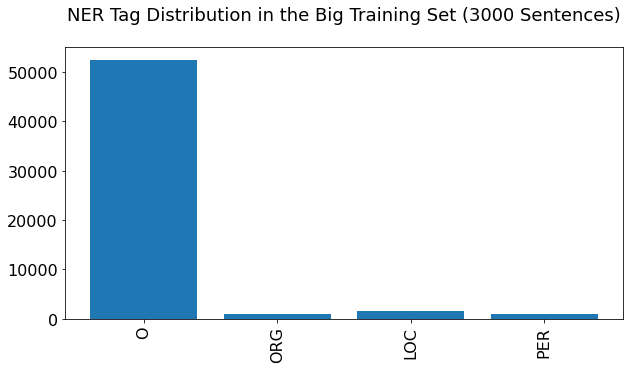

In [13]:
# Plot the distribution of the labels using ids to label mapping
plt.figure(figsize=(10, 5))
plt.bar(range(len(label_counts)), list(label_counts.values()), align='center')
plt.xticks(range(len(label_counts)), list(label_counts.keys()), rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.title('NER Tag Distribution in the Big Training Set (3000 Sentences)\n', fontsize=18)
plt.savefig('ner_tag_dist.png', bbox_inches='tight')
plt.show()

# Tokenization

Here, we tokenize the data. We need a tokenizer/model that can handle our chosen language, i.e., German. Hence, we use a cased multilingual BERT, a pretrained Tokenizer which is freely available on Hugging Face.

In [14]:
# Setup the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

def tokenize_function(text):
    return tokenizer(text, padding='max_length', max_length=512, truncation=True)
    

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

## Preparations to Re-Align Labels with Tokenized Words
After applying the pre-trained tokenizer, we need to re-align the labels with the tokenized words. This is because the tokenizer adds new tags (such as 'CLS' tags), pads the sentence to normalized length and, potentially, splits words into subwords. All of these transformations lead to mis-alignment with the given NER-tag labels. We handle this with the following function `realign_labels`.

In case a word is split into several subwords by the Tokenizer, we assign the NER-tag of the first subword to all subwords. In case a word is padded, we assign the dummy NER-tag -100 to the padded words.

In [15]:
def align_label(texts, labels):
    tokenized_inputs = tokenize_function(texts)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

# Define Dataset Class
This dataset class is used to load the data and tokenize it. It also handles the re-alignment of the labels with the tokenized words.

In [16]:
class DatasetNER(torch.utils.data.Dataset):

    def __init__(self, df):

        lb = [i.split() for i in df['ner'].values.tolist()]
        txt = df['words'].values.tolist()
        self.texts = [tokenizer(str(i),
                               padding='max_length', max_length = 512, truncation=True, return_tensors="pt") for i in txt]
        self.labels = [align_label(i,j) for i,j in zip(txt, lb)]

    def __len__(self):

        return len(self.labels)

    def get_batch_data(self, idx):

        return self.texts[idx]

    def get_batch_labels(self, idx):

        return torch.LongTensor(self.labels[idx])

    def __getitem__(self, idx):

        batch_data = self.get_batch_data(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_data, batch_labels

# Define Model

Here, we define our BERT model. We use the multilingual cased model (bert-base-multilingual-cased).

Note the parameter

In [17]:
from transformers import BertForTokenClassification

class BertModel(torch.nn.Module):

    def __init__(self, freeze_embeds=False):

        super(BertModel, self).__init__()

        self.bert = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(UNIQUE_LABELS))

        if freeze_embeds:
            for param in self.bert.bert.embeddings.parameters():
                param.requires_grad = False

    def forward(self, input_id, mask, label):

        output = self.bert(input_ids=input_id, attention_mask=mask, labels=label, return_dict=False)

        return output

# Training of the Models

Here, we define some training parameters. In order to keep computational costs low, we chose EPOCHS = 2.

In [18]:
LEARNING_RATE = 5e-3
EPOCHS = 2
BATCH_SIZE = 8

In [19]:
def train_loop(model, df_train, df_val):

    train_dataset = DatasetNER(df_train)
    val_dataset = DatasetNER(df_val)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    device = DEVICE

    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    model.to(device)

    best_acc = 0
    best_loss = 1000

    for epoch_num in range(EPOCHS):

        total_acc_train = 0
        total_loss_train = 0

        model.train()

        for train_data, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_data['attention_mask'].squeeze(1).to(device)
            input_id = train_data['input_ids'].squeeze(1).to(device)

            optimizer.zero_grad()
            loss, logits = model(input_id, mask, train_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][train_label[i] != -100]
              label_clean = train_label[i][train_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_train += acc
              total_loss_train += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()

        total_acc_val = 0
        total_loss_val = 0

        for val_data, val_label in val_dataloader:

            val_label = val_label.to(device)
            mask = val_data['attention_mask'].squeeze(1).to(device)
            input_id = val_data['input_ids'].squeeze(1).to(device)

            loss, logits = model(input_id, mask, val_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][val_label[i] != -100]
              label_clean = val_label[i][val_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_val += acc
              total_loss_val += loss.item()

        val_accuracy = total_acc_val / len(df_val)
        val_loss = total_loss_val / len(df_val)

        print(
            f'Epochs: {epoch_num + 1} | Loss: {total_loss_train / len(df_train): .3f} | Accuracy: {total_acc_train / len(df_train): .3f} | Val_Loss: {total_loss_val / len(df_val): .3f} | Accuracy: {total_acc_val / len(df_val): .3f}')

## Model Training Using Small Training Set

Note, since as per assignment description, the validation and test set are the same for this task, we input the "test_df" to the train_loop. Keep in mind that this validation set is only used to print the validation accuracy, i.e., it is **not** used in the model training!! 

After having defined everyhting, we now train the model on the small training set...

In [20]:
model_small = BertModel()
train_loop(model_small, trainSmall_df, test_df)

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Epochs: 1 | Loss:  0.286 | Accuracy:  0.924 | Val_Loss:  0.219 | Accuracy:  0.932


100%|██████████| 125/125 [01:26<00:00,  1.44it/s]


Epochs: 2 | Loss:  0.203 | Accuracy:  0.934 | Val_Loss:  0.192 | Accuracy:  0.936


## Model Training Using Big Training Set

Note, since as per assignment description, the validation and test set are the same for this task, we input the "test_df" to the train_loop. Keep in mind that this validation set is only used to print the validation accuracy, i.e., it is **not** used in the model training!! 

... and on the big training set....

In [42]:
model_big = BertModel()
train_loop(model_big, trainBig_df, test_df)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Epochs: 1 | Loss:  0.217 | Accuracy:  0.933 | Val_Loss:  0.167 | Accuracy:  0.939


100%|██████████| 375/375 [04:20<00:00,  1.44it/s]


Epochs: 2 | Loss:  0.145 | Accuracy:  0.944 | Val_Loss:  0.166 | Accuracy:  0.931


# Model Training Using Big Training Set and Frozen Embeddings

Note, since as per assignment description, the validation and test set are the same for this task, we input the "test_df" to the train_loop. Keep in mind that this validation set is only used to print the validation accuracy, i.e., it is **not** used in the model training!! 

... and on the big training set with frozen emebddings.

In [22]:
model_big_frozen = BertModel(freeze_embeds=True)
train_loop(model_big_frozen, trainBig_df, test_df)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Epochs: 1 | Loss:  0.210 | Accuracy:  0.933 | Val_Loss:  0.153 | Accuracy:  0.943


100%|██████████| 375/375 [04:14<00:00,  1.47it/s]


Epochs: 2 | Loss:  0.140 | Accuracy:  0.946 | Val_Loss:  0.137 | Accuracy:  0.947


## Save the Models

In order to re-use the models later on and to avoid training them over and over again, we save the models using the 'torch.save()' command.

In [43]:
from datetime import datetime
from google.colab import drive

## Mount to Drive
drive.mount('/content/drive')

## Save the models
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

path_small = f'/content/drive/MyDrive/colab_notebooks/ML4NLP/Ex5/models/smallModel_{timestamp}.pt'
path_big = f'/content/drive/MyDrive/colab_notebooks/ML4NLP/Ex5/models/bigModel_{timestamp}.pt'
path_big_frozen = f'/content/drive/MyDrive/colab_notebooks/ML4NLP/Ex5/models/bigModelFrozen_{timestamp}.pt'


# Create folder 'models' if it doesn't exist
if not os.path.exists('/content/drive/MyDrive/colab_notebooks/ML4NLP/Ex5/models'):
    os.makedirs('/content/drive/MyDrive/colab_notebooks/ML4NLP/Ex5/models')


# Save the model in the folder 'model' with the name 'smallModel_<timestamp>.pt' & 'bigModel_<timestamp>.pt' & 'bigModelFrozen_<timestamp>.pt'
torch.save(model_small, path_small)
torch.save(model_big, path_big)
torch.save(model_big_frozen, path_big_frozen)

#print(f"Models saved to {path_small} and {path_big} and {path_big_frozen}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Models

In [49]:
#path_small = f'/content/drive/MyDrive/colab_notebooks/ML4NLP/Ex5/models/smallModel_2022-11-22_20-58-32.pt'
#path_big = f'/content/drive/MyDrive/colab_notebooks/ML4NLP/Ex5/models/bigModel_2022-11-22_20-58-32.pt'
#path_big_frozen = f'/content/drive/MyDrive/colab_notebooks/ML4NLP/Ex5/models/bigModelFrozen_2022-11-27_15-56-49.pt'


#model_small = torch.load(path_small, map_location=torch.device('cpu'))
#model_big = torch.load(path_big, map_location=torch.device('cpu'))
#model_big_frozen = torch.load(path_big_frozen, map_location=torch.device('cpu'))

# Evaluation on Test Set

Next, we define our evaluate() function. This function takes a trained model and a test set as input and returns the flattend labels and predictions. Furthermore, the function prints a classification report for a quick overview of the achieved metrics.

In [25]:
# Define evaluation function
def evaluate(model, df_test):

    test_dataset = DatasetNER(df_test)

    test_dataloader = DataLoader(test_dataset, batch_size=1)

    device = DEVICE

    model.to(device)

    total_acc_test = 0.0

    predictions_flat = []
    labels_flat = []

    for test_data, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_data['attention_mask'].squeeze(1).to(device)

            input_id = test_data['input_ids'].squeeze(1).to(device)

            loss, logits = model(input_id, mask, test_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][test_label[i] != -100]
              label_clean = test_label[i][test_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_test += acc

              predictions_flat.extend(predictions.cpu().numpy())
              labels_flat.extend(label_clean.cpu().numpy())

    print(sklearn.metrics.classification_report(labels_flat, predictions_flat, target_names=labels_to_ids.keys()))
    return labels_flat, predictions_flat

In [26]:
def align_word_ids(texts):
  
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(1)
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(1)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

With this helper function, we can predict the NER tags of a given input sentence. We use this function to do a qualitative analysis of our models using an example sentence.

In [27]:
def evaluate_one_text(model, sentence):
    device = DEVICE

    model.to(device)

    text = tokenizer(sentence, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")

    mask = text['attention_mask'].to(device)
    input_id = text['input_ids'].to(device)
    label_ids = torch.Tensor(align_word_ids(sentence)).unsqueeze(0).to(device)

    logits = model(input_id, mask, None)
    logits_clean = logits[0][label_ids != -100]

    predictions = logits_clean.argmax(dim=1).tolist()
    prediction_label = [ids_to_labels[i] for i in predictions]
    print(sentence)
    print(prediction_label)

## Evaluate the Small Model (Trained on 1000 Sentences)

### First, we evaluate the model on the test set and print a simple classification report.

In [28]:
labels, predictions_small = evaluate(model_small, test_df)

              precision    recall  f1-score   support

         LOC       0.65      0.15      0.25      1678
           O       0.93      1.00      0.96     45770
         ORG       0.79      0.06      0.11       918
         PER       1.00      0.00      0.01       932

    accuracy                           0.93     49298
   macro avg       0.84      0.30      0.33     49298
weighted avg       0.92      0.93      0.91     49298



### Next, we print explicitly the scores asked in the assignment.

In [29]:
## Calculate scores

# Calculate the F1 macro score
f1_macro_score_small = sklearn.metrics.f1_score(labels, predictions_small, average='macro')

# Calculate the F1 micro score
f1_micro_score_small = sklearn.metrics.f1_score(labels, predictions_small, average='micro')

## print scores for small model (3 digits)
print(f"Small model:")
print(f"F1 macro score: {f1_macro_score_small:.3f}")
print(f"F1 micro score: {f1_micro_score_small:.3f}")

Small model:
F1 macro score: 0.331
F1 micro score: 0.932


### Then, we print the confusion matrix to get a better understanding of the errors.

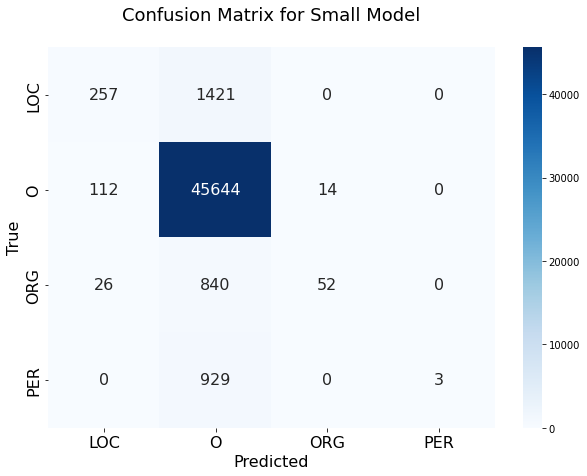

In [30]:
## Calculate Confusion Matrix for small model with labels
cm_small = sklearn.metrics.confusion_matrix(labels, predictions_small)
cm_small = pd.DataFrame(cm_small, index=labels_to_ids.keys(), columns=labels_to_ids.keys())
cm_small

## Plot Confusion Matrix for small model
plt.figure(figsize = (10,7))
sns.heatmap(cm_small, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix for Small Model\n', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('confusion_matrix_smallModel.png', bbox_inches='tight')
plt.show()

### Lastly, we evalute the model on an example sentence and print the predicted NER tags.

In [31]:
evaluate_one_text(model_small, '1980 lief Blanco erstmals für die französische Nationalmannschaft auf als man auf Südafrika traf .')

1980 lief Blanco erstmals für die französische Nationalmannschaft auf als man auf Südafrika traf .
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Evaluate the Big Model (Trained on 3000 Sentences)

### First, we evaluate the model on the test set and print a simple classification report.

In [50]:
labels, predictions_big = evaluate(model_big, test_df)

              precision    recall  f1-score   support

         LOC       0.68      0.33      0.44      1678
           O       0.95      0.99      0.97     45770
         ORG       0.73      0.37      0.49       918
         PER       0.74      0.19      0.31       932

    accuracy                           0.94     49298
   macro avg       0.77      0.47      0.55     49298
weighted avg       0.93      0.94      0.93     49298



### Next, we print explicitly the scores asked in the assignment.

In [51]:
## Calculate scores

# Calculate the F1 macro score
f1_macro_score_big = sklearn.metrics.f1_score(labels, predictions_big, average='macro')

# Calculate the F1 micro score
f1_micro_score_big = sklearn.metrics.f1_score(labels, predictions_big, average='micro')

## print scores for big model (3 digits)
print(f"Big model:")
print(f"F1 macro score: {f1_macro_score_big:.3f}")
print(f"F1 micro score: {f1_micro_score_big:.3f}")

Big model:
F1 macro score: 0.553
F1 micro score: 0.942


### Then, we print the confusion matrix to get a better understanding of the errors.

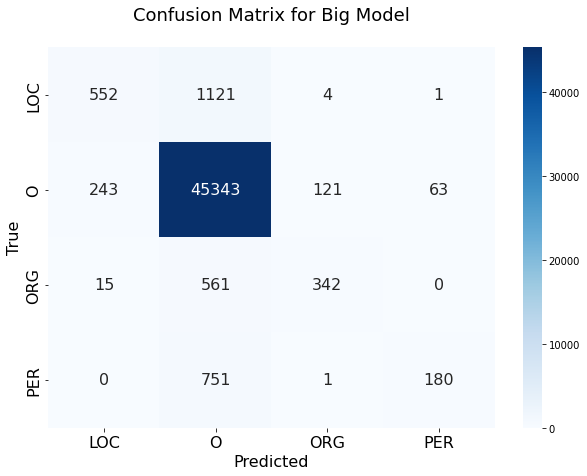

In [54]:
## Calculate Confusion Matrix for big model with labels
cm_big = sklearn.metrics.confusion_matrix(labels, predictions_big)
cm_big = pd.DataFrame(cm_big, index=labels_to_ids.keys(), columns=labels_to_ids.keys())
cm_big

## Plot Confusion Matrix for big model
plt.figure(figsize = (10,7))
sns.heatmap(cm_big, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix for Big Model\n', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('confusion_matrix_bigModel.png', bbox_inches='tight')
plt.show()


### Lastly, we evalute the model on an example sentence and print the predicted NER tags.

In [55]:
evaluate_one_text(model_big, '1980 lief Blanco erstmals für die französische Nationalmannschaft auf als man auf Südafrika traf .')

1980 lief Blanco erstmals für die französische Nationalmannschaft auf als man auf Südafrika traf .
['O', 'O', 'PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Evaluate the Big Model (Trained on 3000 Sentences) And Frozen Embeddings

### First, we evaluate the model on the test set and print a simple classification report.

In [36]:
labels, predictions_big_frozen = evaluate(model_big_frozen, test_df)

              precision    recall  f1-score   support

         LOC       0.59      0.65      0.62      1678
           O       0.97      0.97      0.97     45770
         ORG       0.65      0.54      0.59       918
         PER       0.67      0.46      0.54       932

    accuracy                           0.94     49298
   macro avg       0.72      0.65      0.68     49298
weighted avg       0.94      0.94      0.94     49298



### Next, we print explicitly the scores asked in the assignment.

In [37]:
## Calculate scores

# Calculate the F1 macro score
f1_macro_score_big_frozen = sklearn.metrics.f1_score(labels, predictions_big_frozen, average='macro')

# Calculate the F1 micro score
f1_micro_score_big_frozen = sklearn.metrics.f1_score(labels, predictions_big_frozen, average='micro')

## print scores for big model (3 digits)
print(f"Big model with frozen embeddings:")
print(f"F1 macro score: {f1_macro_score_big_frozen:.3f}")
print(f"F1 micro score: {f1_micro_score_big_frozen:.3f}")

Big model with frozen embeddings:
F1 macro score: 0.680
F1 micro score: 0.945


### Then, we print the confusion matrix to get a better understanding of the errors.

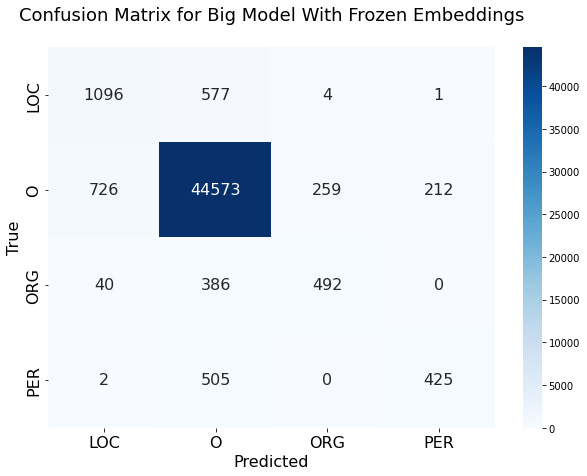

In [38]:
## Calculate Confusion Matrix for big model with labels
cm_big = sklearn.metrics.confusion_matrix(labels, predictions_big_frozen)
cm_big = pd.DataFrame(cm_big, index=labels_to_ids.keys(), columns=labels_to_ids.keys())
cm_big

## Plot Confusion Matrix for big model
plt.figure(figsize = (10,7))
sns.heatmap(cm_big, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix for Big Model With Frozen Embeddings\n', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('confusion_matrix_bigModelFrozen.png', bbox_inches='tight')
plt.show()


### Lastly, we evalute the model on an example sentence and print the predicted NER tags.

In [39]:
evaluate_one_text(model_big_frozen, '1980 lief Blanco erstmals für die französische Nationalmannschaft auf als man auf Südafrika traf .')

1980 lief Blanco erstmals für die französische Nationalmannschaft auf als man auf Südafrika traf .
['O', 'O', 'PER', 'O', 'O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


# Computing Performance Improvements Between Different Models

Here, we compute the performance improvements obtained by using a larger training set and by using frozen embeddings.

In [57]:
# Compute differences in the F1 macro and micro scores

# F1 macro score between small and big model
f1_macro_score_diff = f1_macro_score_big - f1_macro_score_small

# F1 micro score between small and big model
f1_micro_score_diff = f1_micro_score_big - f1_micro_score_small

# Print the differences
print(f"Differences in the F1 macro and micro scores between big and small model:")
print(f"F1 macro score: {f1_macro_score_diff:.3f}")
print(f"F1 micro score: {f1_micro_score_diff:.3f}")

# F1 macro score between big model and big model with frozen embeddings
f1_macro_score_diff = f1_macro_score_big_frozen - f1_macro_score_big

# F1 micro score between big model and big model with frozen embeddings
f1_micro_score_diff = f1_micro_score_big_frozen - f1_micro_score_big

# Print the differences
print(f"Differences in the F1 macro and micro scores between big model and big model with frozen embeddings:")
print(f"F1 macro score: {f1_macro_score_diff:.3f}")
print(f"F1 micro score: {f1_micro_score_diff:.3f}")


Differences in the F1 macro and micro scores between big and small model:
F1 macro score: 0.222
F1 micro score: 0.009
Differences in the F1 macro and micro scores between big model and big model with frozen embeddings:
F1 macro score: 0.127
F1 micro score: 0.003
